In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import files
uploaded = files.upload()

# Load dataset
cols = ['unit', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
       [f'sensor_{i}' for i in range(1, 22)]
df = pd.read_csv('train_FD004.txt', sep='\s+', header=None, names=cols)

# Drop constant sensors
drop_cols = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
df.drop(columns=drop_cols, inplace=True)


Saving train_FD004.txt to train_FD004.txt


In [ ]:
# Calculate RUL
rul = df.groupby('unit')['time_in_cycles'].max().reset_index()
rul.columns = ['unit', 'max_cycle']
df = df.merge(rul, on='unit')
df['RUL'] = df['max_cycle'] - df['time_in_cycles']
df.drop(columns=['max_cycle'], inplace=True)

In [ ]:
# Normalize sensor data
feature_cols = df.columns.difference(['unit', 'time_in_cycles', 'RUL'])
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Sequence generator
def generate_sequences(df, sequence_length=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit]
        for i in range(len(unit_df) - sequence_length + 1):
            seq = unit_df.iloc[i:i+sequence_length]
            X.append(seq[feature_cols].values)
            y.append(seq['RUL'].iloc[-1])
    return np.array(X), np.array(y)

X, y = generate_sequences(df, sequence_length=30)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

Epoch 1/100

Epoch 1: val_loss improved from inf to 2909.06787, saving model to best_model.h5


541/541 - 34s - 64ms/step - loss: 2854.5952 - mean_absolute_error: 38.6536 - root_mean_squared_error: 53.4284 - val_loss: 2909.0679 - val_mean_absolute_error: 41.5694 - val_root_mean_squared_error: 53.9358 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 2909.06787 to 2875.46851, saving model to best_model.h5


541/541 - 27s - 50ms/step - loss: 2808.4490 - mean_absolute_error: 38.4117 - root_mean_squared_error: 52.9948 - val_loss: 2875.4685 - val_mean_absolute_error: 37.3124 - val_root_mean_squared_error: 53.6234 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 2875.46851 to 2525.17578, saving model to best_model.h5


541/541 - 40s - 74ms/step - loss: 2773.7646 - mean_absolute_error: 38.2100 - root_mean_squared_error: 52.6665 - val_loss: 2525.1758 - val_mean_absolute_error: 35.1148 - val_root_mean_squared_error: 50.2511 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 2525.17578 to 2470.84155, saving model to best_model.h5


541/541 - 27s - 50ms/step - loss: 2722.0068 - mean_absolute_error: 37.9317 - root_mean_squared_error: 52.1729 - val_loss: 2470.8416 - val_mean_absolute_error: 34.8909 - val_root_mean_squared_error: 49.7076 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 2470.84155 to 2411.37476, saving model to best_model.h5


541/541 - 40s - 73ms/step - loss: 2735.7891 - mean_absolute_error: 37.9345 - root_mean_squared_error: 52.3048 - val_loss: 2411.3748 - val_mean_absolute_error: 35.6991 - val_root_mean_squared_error: 49.1058 - learning_rate: 5.0000e-04
Epoch 6/100

Epoch 6: val_loss improved from 2411.37476 to 2396.77783, saving model to best_model.h5


541/541 - 25s - 46ms/step - loss: 2657.4575 - mean_absolute_error: 37.3529 - root_mean_squared_error: 51.5505 - val_loss: 2396.7778 - val_mean_absolute_error: 35.1577 - val_root_mean_squared_error: 48.9569 - learning_rate: 5.0000e-04
Epoch 7/100

Epoch 7: val_loss did not improve from 2396.77783
541/541 - 25s - 47ms/step - loss: 2644.6707 - mean_absolute_error: 37.3764 - root_mean_squared_error: 51.4264 - val_loss: 2812.0789 - val_mean_absolute_error: 36.3868 - val_root_mean_squared_error: 53.0290 - learning_rate: 5.0000e-04
Epoch 8/100

Epoch 8: val_loss improved from 2396.77783 to 2378.08179, saving model to best_model.h5


541/541 - 25s - 46ms/step - loss: 2620.2437 - mean_absolute_error: 37.1891 - root_mean_squared_error: 51.1883 - val_loss: 2378.0818 - val_mean_absolute_error: 35.5987 - val_root_mean_squared_error: 48.7656 - learning_rate: 5.0000e-04
Epoch 9/100

Epoch 9: val_loss improved from 2378.08179 to 2298.21265, saving model to best_model.h5


541/541 - 41s - 77ms/step - loss: 2611.2712 - mean_absolute_error: 37.0673 - root_mean_squared_error: 51.1006 - val_loss: 2298.2126 - val_mean_absolute_error: 35.2037 - val_root_mean_squared_error: 47.9397 - learning_rate: 5.0000e-04
Epoch 10/100

Epoch 10: val_loss did not improve from 2298.21265
541/541 - 45s - 82ms/step - loss: 2554.3828 - mean_absolute_error: 36.6448 - root_mean_squared_error: 50.5409 - val_loss: 3212.6655 - val_mean_absolute_error: 39.4771 - val_root_mean_squared_error: 56.6804 - learning_rate: 5.0000e-04
Epoch 11/100

Epoch 11: val_loss did not improve from 2298.21265
541/541 - 39s - 72ms/step - loss: 2521.7092 - mean_absolute_error: 36.5633 - root_mean_squared_error: 50.2166 - val_loss: 2492.9648 - val_mean_absolute_error: 37.6514 - val_root_mean_squared_error: 49.9296 - learning_rate: 5.0000e-04
Epoch 12/100

Epoch 12: val_loss did not improve from 2298.21265
541/541 - 41s - 76ms/step - loss: 2492.4126 - mean_absolute_error: 36.3546 - root_mean_squared_error: 4

541/541 - 26s - 49ms/step - loss: 2356.5923 - mean_absolute_error: 35.3316 - root_mean_squared_error: 48.5447 - val_loss: 2077.9880 - val_mean_absolute_error: 33.5353 - val_root_mean_squared_error: 45.5850 - learning_rate: 2.5000e-04
Epoch 16/100

Epoch 16: val_loss improved from 2077.98804 to 1906.91394, saving model to best_model.h5


541/541 - 27s - 49ms/step - loss: 2333.2339 - mean_absolute_error: 35.1613 - root_mean_squared_error: 48.3036 - val_loss: 1906.9139 - val_mean_absolute_error: 31.3403 - val_root_mean_squared_error: 43.6682 - learning_rate: 2.5000e-04
Epoch 17/100

Epoch 17: val_loss did not improve from 1906.91394
541/541 - 40s - 73ms/step - loss: 2310.1018 - mean_absolute_error: 35.1054 - root_mean_squared_error: 48.0635 - val_loss: 2103.0247 - val_mean_absolute_error: 32.2292 - val_root_mean_squared_error: 45.8587 - learning_rate: 2.5000e-04
Epoch 18/100

Epoch 18: val_loss did not improve from 1906.91394
541/541 - 26s - 49ms/step - loss: 2284.3379 - mean_absolute_error: 34.8675 - root_mean_squared_error: 47.7947 - val_loss: 2097.5867 - val_mean_absolute_error: 33.0221 - val_root_mean_squared_error: 45.7994 - learning_rate: 2.5000e-04
Epoch 19/100

Epoch 19: val_loss did not improve from 1906.91394
541/541 - 40s - 75ms/step - loss: 2260.6311 - mean_absolute_error: 34.7065 - root_mean_squared_error: 4

541/541 - 39s - 73ms/step - loss: 2200.7542 - mean_absolute_error: 34.2539 - root_mean_squared_error: 46.9122 - val_loss: 1876.2090 - val_mean_absolute_error: 31.4158 - val_root_mean_squared_error: 43.3152 - learning_rate: 1.2500e-04
Epoch 23/100

Epoch 23: val_loss did not improve from 1876.20898
541/541 - 42s - 77ms/step - loss: 2197.3447 - mean_absolute_error: 34.2639 - root_mean_squared_error: 46.8758 - val_loss: 1879.7550 - val_mean_absolute_error: 30.7479 - val_root_mean_squared_error: 43.3561 - learning_rate: 1.2500e-04
Epoch 24/100

Epoch 24: val_loss did not improve from 1876.20898
541/541 - 41s - 76ms/step - loss: 2221.6204 - mean_absolute_error: 34.4382 - root_mean_squared_error: 47.1341 - val_loss: 2034.9696 - val_mean_absolute_error: 31.5435 - val_root_mean_squared_error: 45.1106 - learning_rate: 1.2500e-04
Epoch 25/100

Epoch 25: val_loss improved from 1876.20898 to 1716.45935, saving model to best_model.h5


541/541 - 41s - 76ms/step - loss: 2164.7534 - mean_absolute_error: 33.9536 - root_mean_squared_error: 46.5269 - val_loss: 1716.4594 - val_mean_absolute_error: 30.1056 - val_root_mean_squared_error: 41.4302 - learning_rate: 1.2500e-04
Epoch 26/100

Epoch 26: val_loss did not improve from 1716.45935
541/541 - 40s - 73ms/step - loss: 2147.7014 - mean_absolute_error: 33.8855 - root_mean_squared_error: 46.3433 - val_loss: 1881.4713 - val_mean_absolute_error: 30.8489 - val_root_mean_squared_error: 43.3759 - learning_rate: 1.2500e-04
Epoch 27/100

Epoch 27: val_loss did not improve from 1716.45935
541/541 - 41s - 76ms/step - loss: 2171.1851 - mean_absolute_error: 33.9766 - root_mean_squared_error: 46.5960 - val_loss: 1895.0193 - val_mean_absolute_error: 30.6677 - val_root_mean_squared_error: 43.5318 - learning_rate: 1.2500e-04
Epoch 28/100

Epoch 28: val_loss did not improve from 1716.45935
541/541 - 25s - 45ms/step - loss: 2157.3501 - mean_absolute_error: 33.8568 - root_mean_squared_error: 4

541/541 - 26s - 48ms/step - loss: 2091.5894 - mean_absolute_error: 33.4564 - root_mean_squared_error: 45.7339 - val_loss: 1695.7911 - val_mean_absolute_error: 29.4714 - val_root_mean_squared_error: 41.1800 - learning_rate: 6.2500e-05
Epoch 35/100

Epoch 35: val_loss did not improve from 1695.79114
541/541 - 26s - 48ms/step - loss: 2087.6550 - mean_absolute_error: 33.3809 - root_mean_squared_error: 45.6909 - val_loss: 1822.3120 - val_mean_absolute_error: 30.0522 - val_root_mean_squared_error: 42.6885 - learning_rate: 6.2500e-05
Epoch 36/100

Epoch 36: val_loss did not improve from 1695.79114
541/541 - 26s - 48ms/step - loss: 2096.9370 - mean_absolute_error: 33.4308 - root_mean_squared_error: 45.7923 - val_loss: 1792.1918 - val_mean_absolute_error: 29.9057 - val_root_mean_squared_error: 42.3343 - learning_rate: 6.2500e-05
Epoch 37/100

Epoch 37: val_loss did not improve from 1695.79114
541/541 - 41s - 76ms/step - loss: 2091.8723 - mean_absolute_error: 33.4897 - root_mean_squared_error: 4

541/541 - 41s - 76ms/step - loss: 2081.0525 - mean_absolute_error: 33.3573 - root_mean_squared_error: 45.6186 - val_loss: 1683.0077 - val_mean_absolute_error: 29.2713 - val_root_mean_squared_error: 41.0245 - learning_rate: 3.1250e-05
Epoch 41/100

Epoch 41: val_loss did not improve from 1683.00769
541/541 - 39s - 72ms/step - loss: 2056.7590 - mean_absolute_error: 33.1529 - root_mean_squared_error: 45.3515 - val_loss: 1774.2378 - val_mean_absolute_error: 29.7710 - val_root_mean_squared_error: 42.1217 - learning_rate: 3.1250e-05
Epoch 42/100

Epoch 42: val_loss improved from 1683.00769 to 1663.90564, saving model to best_model.h5


541/541 - 42s - 77ms/step - loss: 2049.8303 - mean_absolute_error: 33.0613 - root_mean_squared_error: 45.2751 - val_loss: 1663.9056 - val_mean_absolute_error: 29.0685 - val_root_mean_squared_error: 40.7910 - learning_rate: 3.1250e-05
Epoch 43/100

Epoch 43: val_loss did not improve from 1663.90564
541/541 - 41s - 75ms/step - loss: 2041.3370 - mean_absolute_error: 33.0520 - root_mean_squared_error: 45.1812 - val_loss: 1746.1554 - val_mean_absolute_error: 29.5500 - val_root_mean_squared_error: 41.7870 - learning_rate: 3.1250e-05
Epoch 44/100

Epoch 44: val_loss improved from 1663.90564 to 1622.56262, saving model to best_model.h5


541/541 - 41s - 75ms/step - loss: 2033.9620 - mean_absolute_error: 33.0163 - root_mean_squared_error: 45.0995 - val_loss: 1622.5626 - val_mean_absolute_error: 28.8114 - val_root_mean_squared_error: 40.2810 - learning_rate: 3.1250e-05
Epoch 45/100

Epoch 45: val_loss did not improve from 1622.56262
541/541 - 24s - 45ms/step - loss: 2035.5032 - mean_absolute_error: 33.0063 - root_mean_squared_error: 45.1166 - val_loss: 1721.6697 - val_mean_absolute_error: 29.3951 - val_root_mean_squared_error: 41.4930 - learning_rate: 3.1250e-05
Epoch 46/100

Epoch 46: val_loss did not improve from 1622.56262
541/541 - 24s - 44ms/step - loss: 2038.4764 - mean_absolute_error: 33.0441 - root_mean_squared_error: 45.1495 - val_loss: 1659.2677 - val_mean_absolute_error: 29.0649 - val_root_mean_squared_error: 40.7341 - learning_rate: 3.1250e-05
Epoch 47/100

Epoch 47: val_loss did not improve from 1622.56262
541/541 - 24s - 45ms/step - loss: 2036.1345 - mean_absolute_error: 32.9694 - root_mean_squared_error: 4

541/541 - 41s - 76ms/step - loss: 2038.1315 - mean_absolute_error: 32.9861 - root_mean_squared_error: 45.1457 - val_loss: 1608.5573 - val_mean_absolute_error: 28.6753 - val_root_mean_squared_error: 40.1068 - learning_rate: 3.1250e-05
Epoch 49/100

Epoch 49: val_loss did not improve from 1608.55725
541/541 - 42s - 77ms/step - loss: 2044.1720 - mean_absolute_error: 33.1123 - root_mean_squared_error: 45.2125 - val_loss: 1660.4908 - val_mean_absolute_error: 29.0115 - val_root_mean_squared_error: 40.7491 - learning_rate: 3.1250e-05
Epoch 50/100

Epoch 50: val_loss did not improve from 1608.55725
541/541 - 40s - 75ms/step - loss: 2031.8267 - mean_absolute_error: 32.9540 - root_mean_squared_error: 45.0758 - val_loss: 1655.5229 - val_mean_absolute_error: 28.9474 - val_root_mean_squared_error: 40.6881 - learning_rate: 3.1250e-05
Epoch 51/100

Epoch 51: val_loss did not improve from 1608.55725
541/541 - 41s - 75ms/step - loss: 2017.6610 - mean_absolute_error: 32.9644 - root_mean_squared_error: 4

541/541 - 41s - 76ms/step - loss: 2007.5581 - mean_absolute_error: 32.7663 - root_mean_squared_error: 44.8058 - val_loss: 1561.3229 - val_mean_absolute_error: 28.5121 - val_root_mean_squared_error: 39.5136 - learning_rate: 3.1250e-05
Epoch 54/100

Epoch 54: val_loss did not improve from 1561.32288
541/541 - 39s - 71ms/step - loss: 2029.0043 - mean_absolute_error: 32.9102 - root_mean_squared_error: 45.0445 - val_loss: 1635.0369 - val_mean_absolute_error: 28.9258 - val_root_mean_squared_error: 40.4356 - learning_rate: 3.1250e-05
Epoch 55/100

Epoch 55: val_loss did not improve from 1561.32288
541/541 - 42s - 77ms/step - loss: 2023.9935 - mean_absolute_error: 32.9213 - root_mean_squared_error: 44.9888 - val_loss: 1655.4530 - val_mean_absolute_error: 28.9675 - val_root_mean_squared_error: 40.6873 - learning_rate: 3.1250e-05
Epoch 56/100

Epoch 56: val_loss did not improve from 1561.32288
541/541 - 41s - 76ms/step - loss: 2006.1813 - mean_absolute_error: 32.7397 - root_mean_squared_error: 4

In [ ]:
# Already done in step 6
# history = model.fit(...)

# Extract metrics
history_dict = history.history

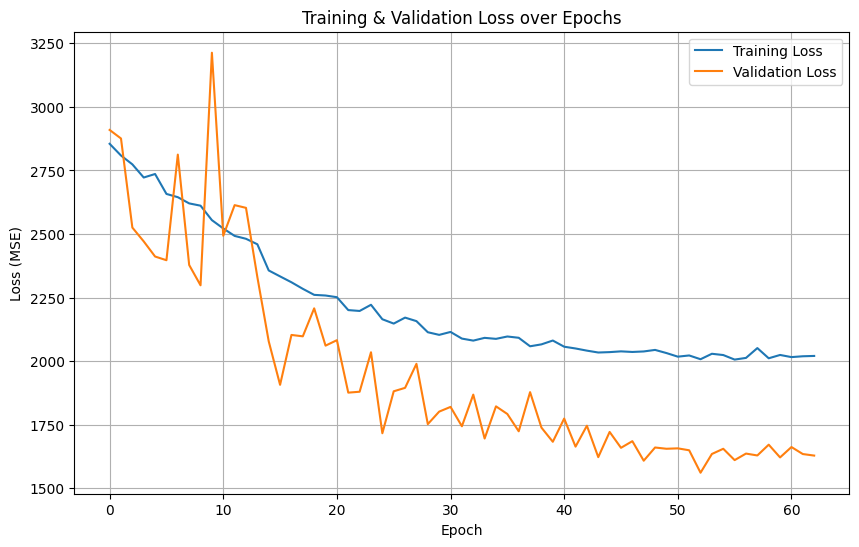

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

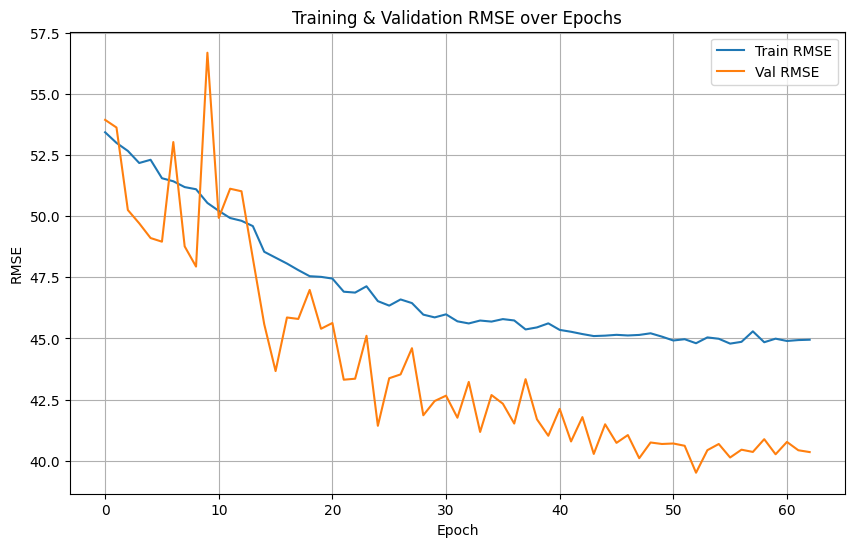

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_dict['root_mean_squared_error'], label='Train RMSE')
plt.plot(history_dict['val_root_mean_squared_error'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training & Validation RMSE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

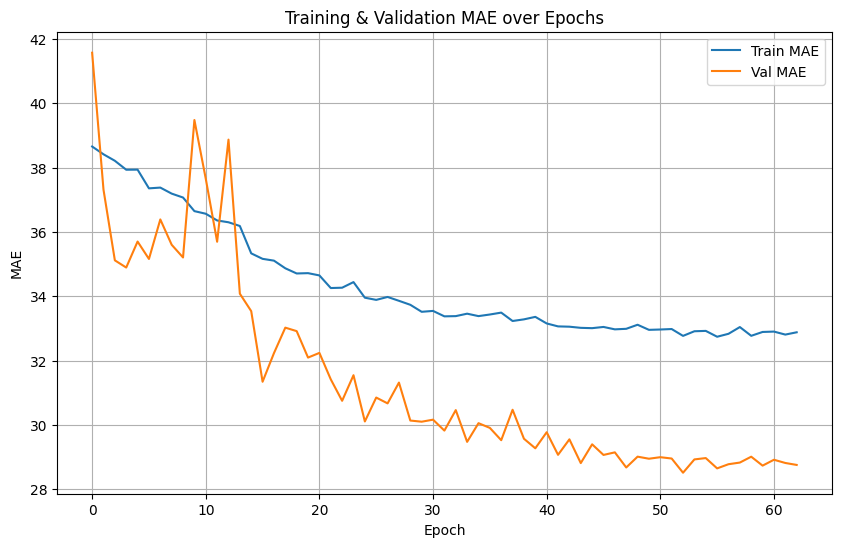

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_dict['mean_absolute_error'], label='Train MAE')
plt.plot(history_dict['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training & Validation MAE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


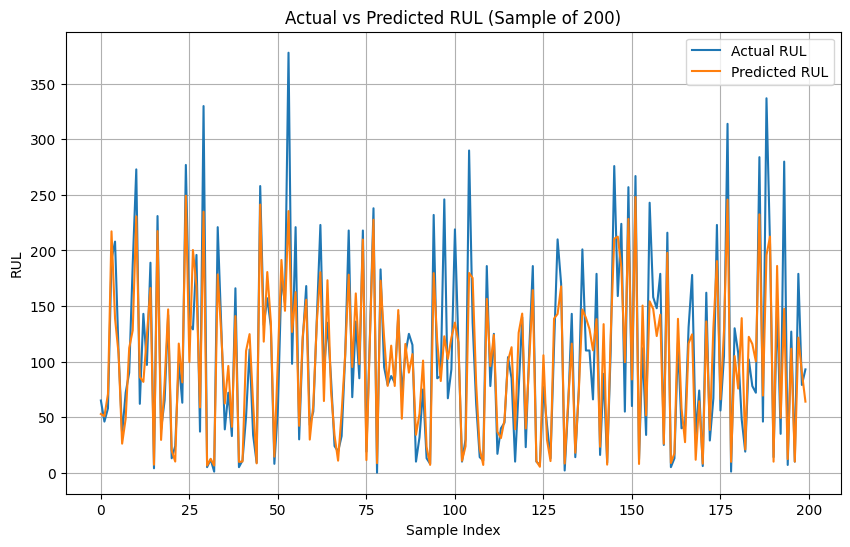

In [ ]:
# Predict on test set
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_test[:200], label='Actual RUL')
plt.plot(y_pred[:200], label='Predicted RUL')
plt.title("Actual vs Predicted RUL (Sample of 200)")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()

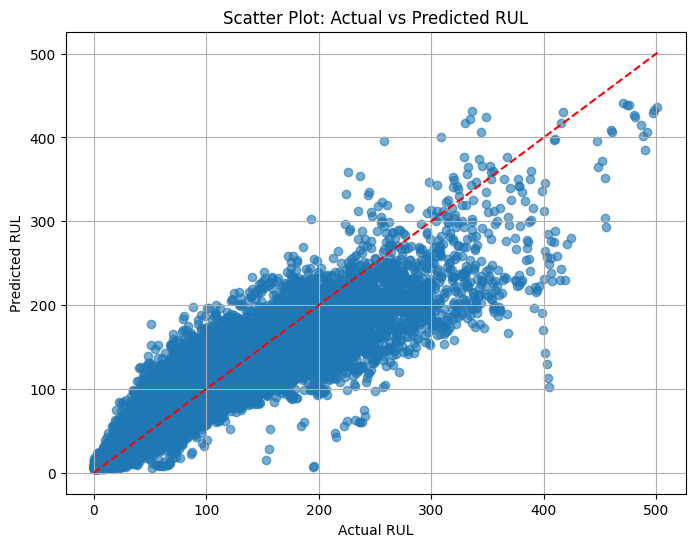

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Scatter Plot: Actual vs Predicted RUL')
plt.grid(True)
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/

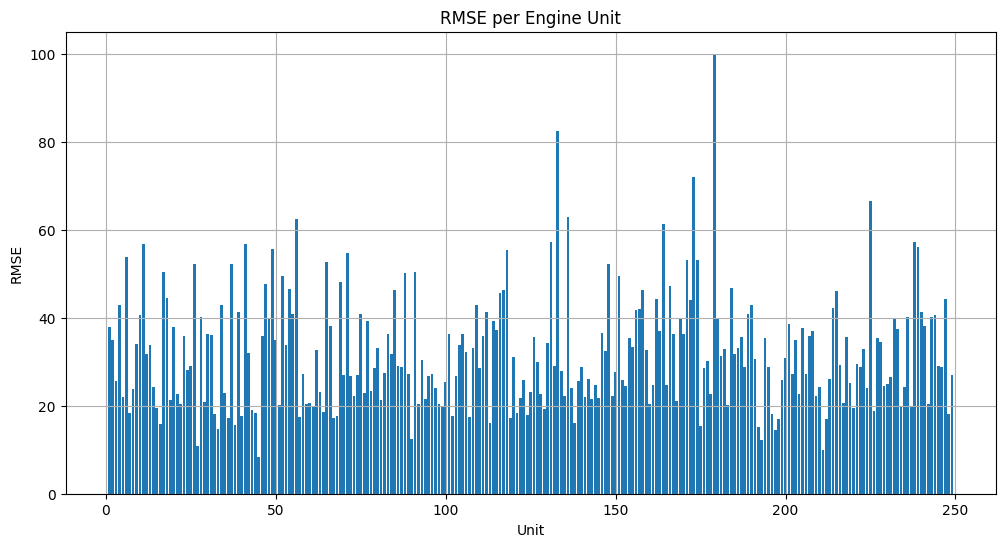

In [ ]:
from sklearn.metrics import mean_squared_error

unit_rmse = []
for unit in df['unit'].unique():
    unit_df = df[df['unit'] == unit]
    X_unit, y_unit = generate_sequences(unit_df, sequence_length=30)
    if len(X_unit) > 0:
        y_pred_unit = model.predict(X_unit).flatten()
        rmse = np.sqrt(mean_squared_error(y_unit, y_pred_unit))
        unit_rmse.append((unit, rmse))

unit_rmse_df = pd.DataFrame(unit_rmse, columns=['unit', 'RMSE'])

# Plot
plt.figure(figsize=(12, 6))
plt.bar(unit_rmse_df['unit'], unit_rmse_df['RMSE'])
plt.xlabel('Unit')
plt.ylabel('RMSE')
plt.title('RMSE per Engine Unit')
plt.grid(True)
plt.show()

In [ ]:
loss, mae, rmse = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1595.3445 - mean_absolute_error: 27.9484 - root_mean_squared_error: 39.9259
Test Loss (MSE): 1607.34
Test MAE: 28.27
Test RMSE: 40.09


338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


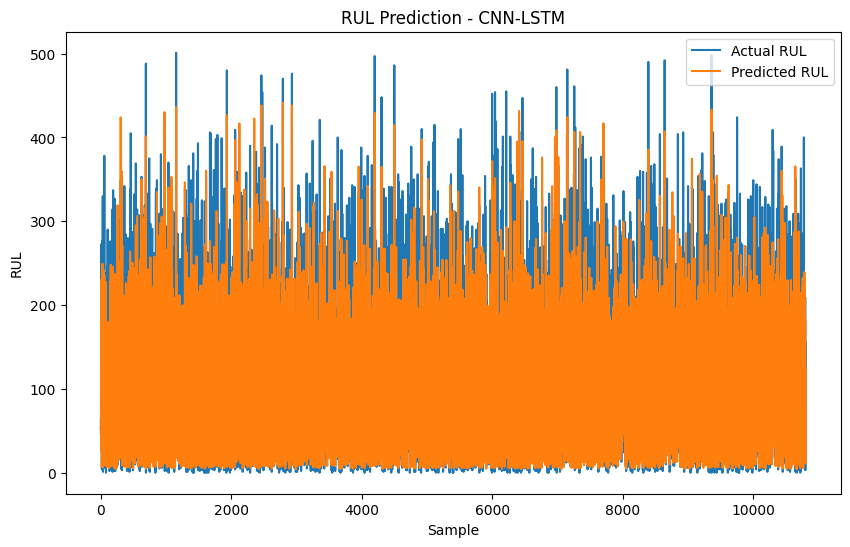

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel("Sample")
plt.ylabel("RUL")
plt.title("RUL Prediction - CNN-LSTM")
plt.legend()
plt.show()

In [ ]:
def plot_cnn_lstm_prediction(model, engine_id, sequence_length=30, threshold_ratio=0.3):
    # Extract data for a specific engine
    engine_df = df[df['unit'] == engine_id].reset_index(drop=True)

    # Generate sequences
    X_engine = []
    for i in range(len(engine_df) - sequence_length + 1):
        seq = engine_df.iloc[i:i+sequence_length][feature_cols].values
        X_engine.append(seq)
    X_engine = np.array(X_engine)

    # Predict RUL
    y_pred = model.predict(X_engine).flatten()
    actual_rul = engine_df['RUL'][sequence_length - 1:].values

    # Define warning threshold (30% of initial predicted RUL)
    initial_rul = y_pred[0]
    threshold = threshold_ratio * initial_rul

    # Find first point where predicted RUL < 30% of initial
    below_threshold_idx = np.argmax(y_pred < threshold)
    if y_pred[below_threshold_idx] >= threshold:
        below_threshold_idx = None

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(actual_rul, label='Actual RUL', linestyle='--')
    plt.plot(y_pred, label='Predicted RUL', linewidth=2)

    if below_threshold_idx is not None:
        plt.axvline(x=below_threshold_idx, color='r', linestyle=':', label='30% RUL Warning')
        plt.text(below_threshold_idx, threshold + 5, 'Warning Triggered', color='red')

    plt.axhline(y=threshold, color='orange', linestyle='--', label='30% Threshold')
    plt.title(f'Engine {engine_id} - RUL Prediction with Warning')
    plt.xlabel('Cycle Index')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True)
    plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


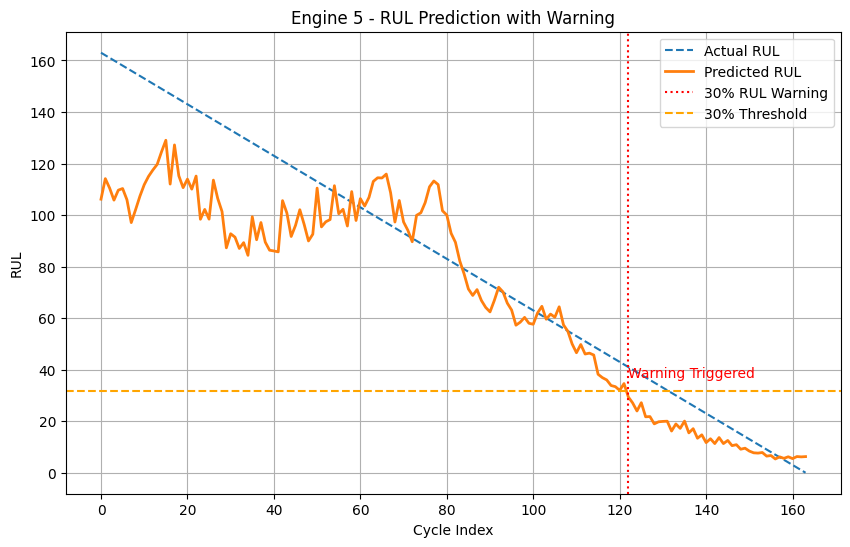

In [ ]:
plot_cnn_lstm_prediction(model, engine_id=5)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test).flatten()

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mask = y_test != 0
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
print(f"Fixed MAPE: {mape:.2f}%")


print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")
print(f"MAPE : {mape:.2f}%")

338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Fixed MAPE: 34.09%
MAE  : 28.27
RMSE : 40.09
R²   : 0.77
MAPE : 34.09%


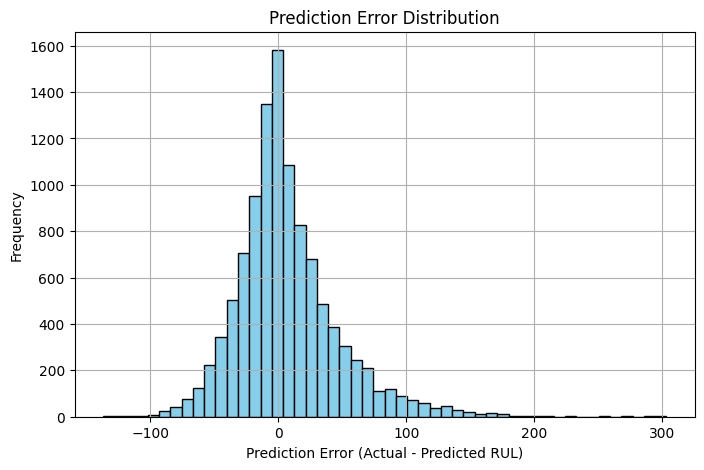

In [ ]:
import matplotlib.pyplot as plt

errors = y_test - y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (Actual - Predicted RUL)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def final_dashboard(model, X_test, y_test, sample_engine_id=5, sequence_length=30):
    # Predictions
    y_pred = model.predict(X_test).flatten()

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display metrics
    print("📊 Final Test Metrics")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    # Plot 1: Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual RUL', alpha=0.7)
    plt.plot(y_pred, label='Predicted RUL', alpha=0.7)
    plt.title("Actual vs Predicted RUL on Test Set")
    plt.xlabel("Sample Index")
    plt.ylabel("RUL")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Error Distribution
    errors = y_test - y_pred
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
    plt.title("Prediction Error Distribution")
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plot 3: RUL Warning on Sample Engine
    print(f"\n🚨 Sample Engine Warning (unit {sample_engine_id})")
    plot_cnn_lstm_prediction(model, engine_id=sample_engine_id, sequence_length=sequence_length)

338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
📊 Final Test Metrics
MAE  : 28.27
RMSE : 40.09
R²   : 0.77


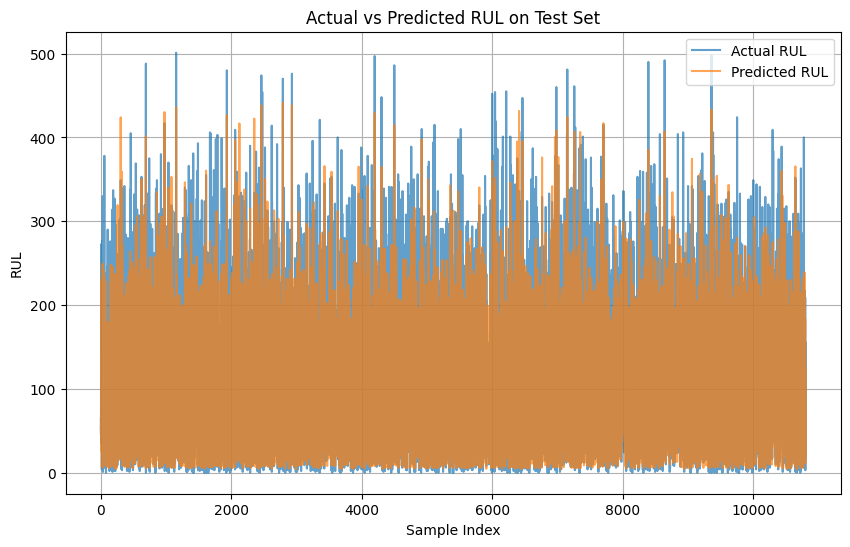

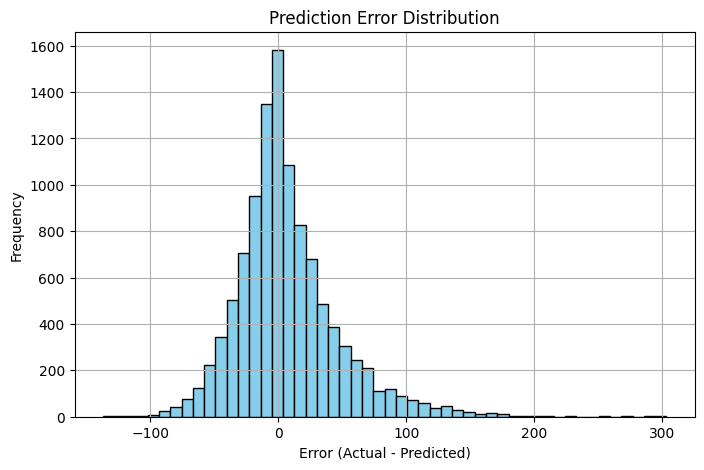


🚨 Sample Engine Warning (unit 5)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


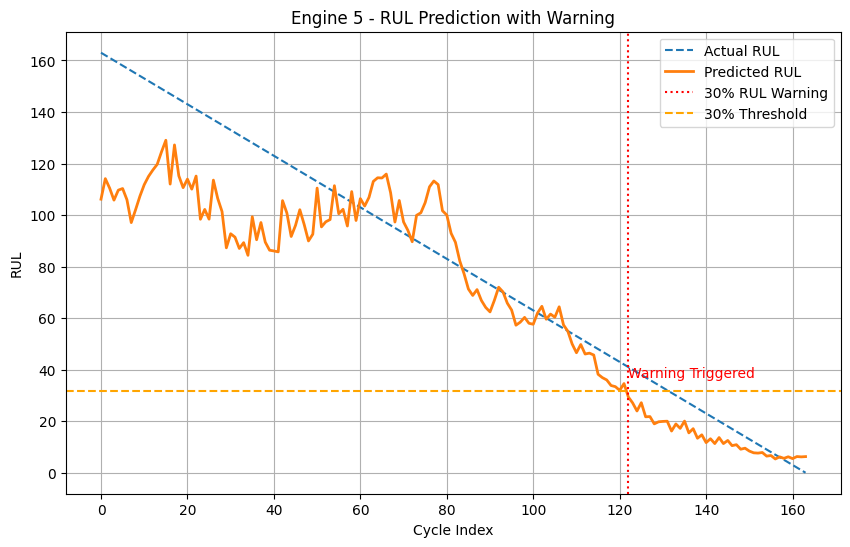

In [ ]:
final_dashboard(model, X_test, y_test, sample_engine_id=5)

In [ ]:
model.save("cnn_lstm_rul_model.h5")
print("✅ Model saved successfully!")

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("cnn_lstm_rul_model.h5")
print("✅ Model loaded successfully!")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'cnn_lstm_rul_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Predict if not already done
y_pred = model.predict(X_test).flatten()

# Compute accuracy
acc = regression_accuracy(y_test, y_pred, tolerance=10)
r2 = r2_score(y_test, y_pred)

print(f"🎯 Regression Accuracy (±10 cycles): {acc:.2f}%")
print(f"📈 R² Score: {r2:.2f}")


NameError: name 'model' is not defined